# Optimization Assignment

## Instructions:

1. Clone this repository (or just pull changes if you already have it).
2. Start Jupyter (don't forget to select the correct kernel/environment).
3. Duplicate this file so that you can still pull changes without merging.
4. Complete the "Things to Implement."

## Things to Implement

1. Momentum

$$
\begin{align}
m_{t+1} &:= β_m m_t + (1 - β_m) \nabla_θ L_b(θ_t) \\
θ_{t+1} &:= θ_t - η m_{t+1}
\end{align}
$$

2. RMSProp

$$
\begin{align}
g_{t+1}^2 &:= β_g g_t^2 + (1 - β_g) (\nabla_θ L_b(θ_t))^2 \\
θ_{t+1} &:= θ_t - η \frac{\nabla_θ L_b(θ_t)}{\sqrt{g_{t+1}^2} + ε}
\end{align}
$$

3. Adam

$$
\begin{align}
m_{t+1} &:= β_m m_t + (1 - β_m) \nabla_θ L_b(θ_t) \\
\hat m_{t+1} &:= \frac{m_{t+1}}{1 - β_m^t} \\
g_{t+1}^2 &:= β_g g_t^2 + (1 - β_g) (\nabla_θ L_b(θ_t))^2 \\
\hat g_{t+1}^2 &:= \frac{g_{t+1}^2}{1 - β_g^t} \\
θ_{t+1} &:= θ_t - η \frac{\hat m_{t+1}}{\sqrt{\hat g_{t+1}^2} + ε}
\end{align}
$$


A few hints:

- Run the code all the way through without any changes and answer the first question on gradescope
- Adam combines momentum and RMSProp (and in this case adds a bias correction)
- $t$ increments after each update (the actual value of $t$ is only used in Adam)
- You'll need to add code in two places (look for @assignment)
    1. At the top of the training cell (to initialize momentums and squared gradients)
    2. In the parameter update context manager (where you'll find `param -= ...`)
- The documentation for [torch.optim.Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) will give good values for $\beta_m$ and $\beta_g$
- If momentum performs poorly, then it might be that you are not updating momentum values **in-place**

## Import Libraries

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from torchsummary import summary

from torchvision.datasets import FashionMNIST
from torchvision.transforms import Compose, Normalize, ToTensor

from fastprogress.fastprogress import master_bar, progress_bar

import matplotlib.pyplot as plt
from jupyterthemes import jtplot

jtplot.style(context="talk")

## Set Hyperparameters

In [2]:
data_path = "~/data"

# Use the GPUs if they are available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using '{device}' device.")

# Model hyperparameters
neurons_per_hidden_layer = [13, 17]

# Mini-Batch SGD hyperparameters
batch_size = 256
num_epochs = 10
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()

Using 'cuda' device.


## Prepare the Dataset

In [3]:
def get_fmnist_data_loaders(path, batch_size, valid_batch_size=0):

    # Data specific transforms (@normalization: I computed data_mean and data_std as shown in the next cell)
    data_mean = (0.2860,)
    data_std = (0.3530,)
    xforms = Compose([ToTensor(), Normalize(data_mean, data_std)])

    # Training data loader
    train_dataset = FashionMNIST(root=path, train=True, download=True, transform=xforms)

    # Set the batch size to N if batch_size is 0
    tbs = len(train_dataset) if batch_size == 0 else batch_size
    train_loader = DataLoader(train_dataset, batch_size=tbs, shuffle=True)

    # Validation data loader
    valid_dataset = FashionMNIST(root=path, train=False, download=True, transform=xforms)

    # Set the batch size to N if batch_size is 0
    vbs = len(valid_dataset) if valid_batch_size == 0 else valid_batch_size
    valid_loader = DataLoader(valid_dataset, batch_size=vbs, shuffle=True)

    return train_loader, valid_loader

In [4]:
# Computing normalization constants for Fashion-MNIST
# (Commented out since we only need to do this once; and I've done it for you. See @normalization.)
# train_loader, valid_loader = get_fmnist_data_loaders(data_path, 0)
# X, _ = next(iter(train_loader))
# s, m = torch.std_mean(X)

train_loader, valid_loader = get_fmnist_data_loaders(data_path, batch_size)

print("Training dataset shape   :", train_loader.dataset.data.shape)
print("Validation dataset shape :", valid_loader.dataset.data.shape)

Training dataset shape   : torch.Size([60000, 28, 28])
Validation dataset shape : torch.Size([10000, 28, 28])


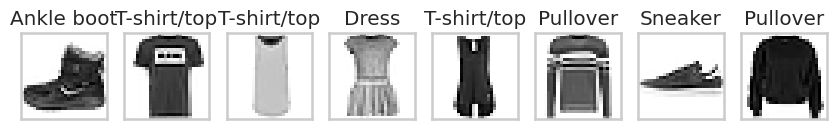

In [5]:
# Let's plot a few images as an example
num_to_show = 8
images = train_loader.dataset.data[:num_to_show]
targets = train_loader.dataset.targets[:num_to_show]
labels = [train_loader.dataset.classes[t] for t in targets]

fig, axes = plt.subplots(1, num_to_show)

for axis, image, label in zip(axes, images, labels):
    axis.imshow(image.squeeze(), cmap="Greys")
    axis.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_title(f"{label}")

## Create a Neural Network

In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self, layer_sizes):
        super(NeuralNetwork, self).__init__()

        # The first "layer" just rearranges the Nx28x28 input into Nx784
        # NOTE: this layer is not trained
        first_layer = nn.Flatten()

        # The hidden layers include:
        # 1. a linear component (computing Z; with parameters W and b) and
        # 2. a non-linear comonent (computing A; called an activation function)
        hidden_layers = [
            nn.Sequential(nn.Linear(nlminus1, nl), nn.ReLU())
            for nl, nlminus1 in zip(layer_sizes[1:-1], layer_sizes)
        ]

        # The output layer must be Linear without an activation. See:
        #   https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
        output_layer = nn.Linear(layer_sizes[-2], layer_sizes[-1])

        # Group all layers into the sequential container
        all_layers = [first_layer] + hidden_layers + [output_layer]
        self.layers = nn.Sequential(*all_layers)

    def forward(self, X):
        return self.layers(X)

In [7]:
# The input layer size depends on the dataset
nx = train_loader.dataset.data.shape[1:].numel()

# The output layer size depends on the dataset
ny = len(train_loader.dataset.classes)

# Preprend the input and append the output layer sizes
layer_sizes = [nx] + neurons_per_hidden_layer + [ny]

# Create the model and set it to use the GPU if available
model = NeuralNetwork(layer_sizes).to(device)

summary(model);

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Flatten: 2-1                      --
|    └─Sequential: 2-2                   --
|    |    └─Linear: 3-1                  10,205
|    |    └─ReLU: 3-2                    --
|    └─Sequential: 2-3                   --
|    |    └─Linear: 3-3                  238
|    |    └─ReLU: 3-4                    --
|    └─Linear: 2-4                       180
Total params: 10,623
Trainable params: 10,623
Non-trainable params: 0


## Train Classifier

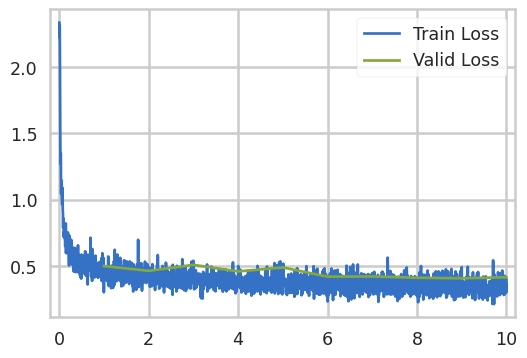

In [8]:
# Copying model creation here so that the model is recreated each time the cell is run
model = NeuralNetwork(layer_sizes).to(device)

t = 0

# 
# @assignment Initializations code for momentum, RMSProp, and Adam
#
# momentum intialization
beta_m = 0.9
momentums = []
for param in model.parameters():
    momentums.append(torch.zeros_like(param))
    
# RMSProp initialization
beta_g = 0.999
eps = 1e-08
sq_grads = []
for param in model.parameters():
    sq_grads.append(torch.zeros_like(param))

# A master bar for fancy output progress
mb = master_bar(range(num_epochs))

# Information for plots
mb.names = ["Train Loss", "Valid Loss"]
train_losses = []
valid_losses = []

for epoch in mb:

    #
    # Training
    #
    model.train()

    train_N = len(train_loader.dataset)
    num_train_batches = len(train_loader)
    train_dataiterator = iter(train_loader)

    train_loss_mean = 0

    for batch in progress_bar(range(num_train_batches), parent=mb):

        # Grab the batch of data and send it to the correct device
        train_X, train_Y = next(train_dataiterator)
        train_X, train_Y = train_X.to(device), train_Y.to(device)

        # Compute the output
        train_output = model(train_X)

        # Compute loss
        train_loss = criterion(train_output, train_Y)

        num_in_batch = len(train_X)
        tloss = train_loss.item() * num_in_batch / train_N
        train_loss_mean += tloss
        train_losses.append(train_loss.item())

        # Compute partial derivatives
        model.zero_grad()
        train_loss.backward()
        
        t += 1
        with torch.no_grad():
            
            # Original gradient descent
            
            # for param in model.parameters():
            #     # θ_{t+1} := θ_t - η \nabla_θ L_b(θ_t)
            #     param -= learning_rate * param.grad

            # 
            # @assignment
            # NOTE: only one should run at a time
            #

            # @assignment-momentum
            # Gradient descent with momentum
            # for param, momentum in ...
            #     m_{t+1} := β_m m_t + (1 - β_m) \nabla_θ L_b(θ_t)
            #     θ_{t+1} := θ_t - η m_{t+1}
            
            # for param, momentum in zip(model.parameters(), momentums):
            #     momentum.set_(beta_m*momentum + (1 - beta_m)*param.grad)
            #     param -= learning_rate * momentum


            # @assignment-rmsprop
            # Gradient descent with RMSProp
            # for param, sq_grad in ...
            #     g_{t+1}^2 := β_g g_t^2 + (1 - β_g) (\nabla_θ L_b(θ_t))^2
            #     θ_{t+1} := θ_t - η \frac{\nabla_θ L_b(θ_t)}{\sqrt{g_{t+1}^2} + ε}
            
            for param, sq_grad in zip(model.parameters(), sq_grads):
                sq_grad.set_(beta_g*sq_grad + (1 - beta_g) * (param.grad ** 2))
                param -= learning_rate * (param.grad / (torch.sqrt(sq_grad) + eps))

            # @assignment-adam
            # Gradient descent with Adam
            # for param, momentum, sq_grad in ...
            #     m_{t+1} := β_m m_t + (1 - β_m) \nabla_θ L_b(θ_t)
            #     \hat m_{t+1} := \frac{m_{t+1}}{1 - β_m^t}
            #     g_{t+1}^2 := β_g g_t^2 + (1 - β_g) (\nabla_θ L_b(θ_t))^2
            #     \hat g_{t+1}^2 := \frac{g_{t+1}^2}{1 - β_g^t}
            #     θ_{t+1} := θ_t - η \frac{\hat m_{t+1}}{\sqrt{\hat g_{t+1}^2} + ε}

    #
    # Validation
    #
    
    model.eval()

    valid_N = len(valid_loader.dataset)
    num_valid_batches = len(valid_loader)

    valid_loss_mean = 0
    valid_correct = 0

    with torch.no_grad():

        # valid_loader is probably just one large batch, so not using progress bar
        for valid_X, valid_Y in valid_loader:

            valid_X, valid_Y = valid_X.to(device), valid_Y.to(device)

            valid_output = model(valid_X)

            valid_loss = criterion(valid_output, valid_Y)

            num_in_batch = len(valid_X)
            vloss = valid_loss.item() * num_in_batch / valid_N
            valid_loss_mean += vloss
            valid_losses.append(valid_loss.item())

            # Convert network output into predictions (one-hot -> number)
            predictions = valid_output.argmax(1)

            # Sum up total number that were correct
            valid_correct += (predictions == valid_Y).type(torch.float).sum().item()

    valid_accuracy = 100 * (valid_correct / valid_N)

    # Report information
    tloss = f"Train Loss = {train_loss_mean:.4f}"
    vloss = f"Valid Loss = {valid_loss_mean:.4f}"
    vaccu = f"Valid Accuracy = {(valid_accuracy):>0.1f}%"
    mb.write(f"[{epoch+1:>2}/{num_epochs}] {tloss}; {vloss}; {vaccu}")

    # Update plot data
    max_loss = max(max(train_losses), max(valid_losses))
    min_loss = min(min(train_losses), min(valid_losses))

    x_margin = 0.2
    x_bounds = [0 - x_margin, num_epochs + x_margin]

    y_margin = 0.1
    y_bounds = [min_loss - y_margin, max_loss + y_margin]

    valid_Xaxis = torch.linspace(0, epoch + 1, len(train_losses))
    valid_xaxis = torch.linspace(1, epoch + 1, len(valid_losses))
    graph_data = [[valid_Xaxis, train_losses], [valid_xaxis, valid_losses]]

    mb.update_graph(graph_data, x_bounds, y_bounds)